# Handwritten Digit Recognition
### Using MNIST, Keras and OpenCV
---

**Dataset**: [MNIST](http://yann.lecun.com/exdb/mnist/)
* `x_train, y_train`: contains  60 000 training images, and labels
* `x_test, y_test`: contains  10 000 test images, and labels


**Idea**: We will train a Fully Connected Neural Network to perform real time prediction on hand written images using your built in PC-webcamera.

> A key part in achieving this is succesfully preprocessing the images fed  from our webcamera to be as equal to the images the model will be trained on. In other words, we will attempt to create a MNIST preprocessing pipeline.

By [William Kvaale](https://github.com/wQuole)



### Import all the libraries and modules needed

In [1]:
# NumPy - math library for handling matrices and arrays
import numpy as np

# MNIST dataset containing over 60 000 training and 10 000 test examples
from keras.datasets import mnist

# OpenCV - Opensource Computer Vision library
import cv2 as cv

# Matplotlib's PyPlot - visualization library
import matplotlib.pyplot as plt

# Pandas - Data Analysis library
import pandas as pd

#  Keras is Tensorflow's high level API for Deep Learning
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Flatten
from keras.utils import to_categorical

## 1. Load and visualize the data
<details><summary>Hint: </summary>
<p>
    
https://keras.io/api/datasets/mnist/
    
</p>

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

### Let's visualize the distribution of the data

In [3]:
def visualize_distribution(data):
    df = pd.DataFrame.from_records([data])
    df = df.T
    df.rename(columns = {0: 'target'}, inplace=True)
    count = df['target'].value_counts().sort_index()
    count.plot.bar(color=plt.cm.Paired(np.arange(len(count))))

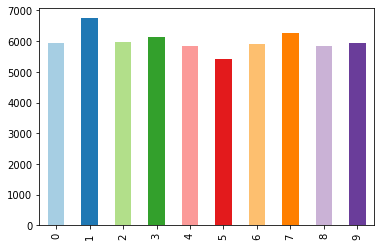

In [4]:
visualize_distribution(y_train)

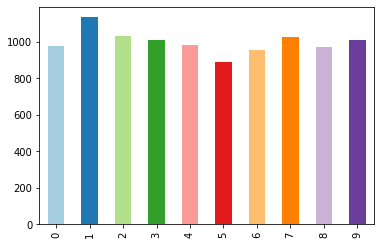

In [5]:
visualize_distribution(y_test)

**Discuss with your partner**:

what _could_ be the result of different distribution in training- and test data?

### Let's visualize an example of every digit (0-9) from the training set  

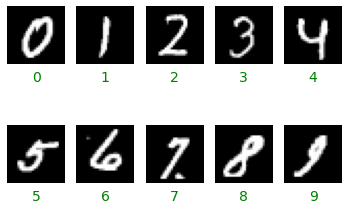

In [6]:
for i in range(10):
    ith_number = np.where(y_train == i)[0]
    random_index_number = ith_number[np.random.randint(0, (len(ith_number)))]
    plt.subplot(2, 5, i+1)
    plt.title(f"{y_train[random_index_number]}", y=-0.4, fontdict={'fontsize':14, 'color': 'green'})
    plt.axis('off')
    plt.imshow(x_train[random_index_number], cmap='gray')

plt.show()

**Any thoughts on the data?**

## 2. Prepare the data

**What does our data look like, raw?**

In [7]:
print(f"y_train:\n{y_train[0]}")

print(f"x_train:\n{x_train[0]}")

y_train:
5
x_train:
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 253 25

<details><summary> Click here for a more clear example  </summary>
<p>
    
<img src="images/mnist_array_example.jpeg" width="500"/>
<a href="https://towardsdatascience.com/how-to-teach-a-computer-to-see-with-convolutional-neural-networks-96c120827cd1">[Image Source]</a>
</p>

**What is the shape (dimensions) of our data?**

In [8]:
x_train.shape

(60000, 28, 28)

### We would like to add another dimension to our images
In other words, converting the shape from (28, 28) to (28, 28, 1).

This will describe that our image has _one_ channel, and is grayscale. 
> FYI: A colored (RGB) image has 3 channels (e.g. (28, 28, 3))

We do this in order to be able to use **Keras' Conv2D layer** which expects the format of the data to be: `(batch_size, height, width, channels)`.

<details><summary>Hint</summary>
<p>
        
[Link to Numpy docs (np.reshape)](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html)
    
```python
data.reshape(NUMBER_OF_IMAGES, HEIGHT, WIDTH, CHANNELS)
```
    
</p>
</details>

In [9]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

In [10]:
x_train.shape

(60000, 28, 28, 1)

### Normalize the data
The pixel intensity in a images is in the range between `[0, 255]`. We would like to normalize this to `[0.0, 1.0]`.
> Artificial Neural Networks processes the input data by updating its so called weights. This process can be disrupted by large integer values, and the training process can be slowed down.

In [11]:
def normalize(data):
    data = data.astype('float32')
    data /= 255
    return data

In [12]:
x_train = normalize(x_train)
x_test = normalize(x_test)

### One-Hot Encoding
Most machine learning algorithms are not able to train on labeled data, e.g. "cat", "dog". This needs to be converted into a numerical representation. This step is called **integer encoding**. However, by just converting "cat" to 1, and "dog" to 2, we are making an unjustified assumption that there exists a **natural ordinal ordering**. This would be the case if our data were, e.g.,  $\{male,\ female,\ child\} \rightarrow \{0, 1 , 2\}$ as in the Titanic data set used in the [Intro to Data Science Course](https://github.com/BRAIN-NTNU/data-science-course/blob/master/%5BSolution%5D%20Data%20Science%20Course%20-%20Titanic.ipynb).

Therefore, we need to **one-hot encode** our data. This way we can represent categorical data, in a numerical way, without assuming anything about its ordering.
![image-2.png](images/one_hot_encoding.jpeg)
[[Image source](https://medium.com/@michaeldelsole/what-is-one-hot-encoding-and-how-to-do-it-f0ae272f1179)]

In [13]:
y_train.shape

(60000,)

<details><summary>Hint: </summary>
<p>
    
https://keras.io/api/utils/python_utils/#to_categorical-function
    
</p>

<details><summary>Hint 2: </summary>
<p>
    
```python
    data = to_categorical(data, num_classes=NUM_CLASSES)
```
</p>

In [14]:
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [15]:
y_train.shape

(60000, 10)

In [16]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

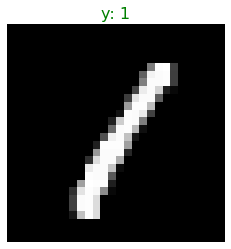

In [17]:
random_number = np.random.randint(0, len(x_train))

number = np.where(y_train[random_number] == 1)[0][0]

plt.axis('off')
plt.imshow(x_train[random_number], cmap='gray')
plt.title(f"y: {number}", fontdict={'fontsize':16, 'color': 'green'})
plt.show()

## 3. Let's define a model

We will define a Vanilla Fully Connected Feed Forward Neural Network. This might sound very complicated, but in should not discourage the upcomming machine learning apprentice.

In order for the network to find non-linear relationships in the data, we use **activation functions**. One activation function that is quite common these day are the ReLu function.
$$ ReLu = max(0, x)$$


Our network will output a `1x10 vector` representing the _probability_ for each number. This is done using **softmax**. 
$$ S(y_i) = \frac{e^{y_i}}{\sum_{i=0}^{n=9}{e^{y_i}}}$$

All the probabilities inside the outputted vector will sum to 1.
You can read more about Softmax [here](https://medium.com/data-science-bootcamp/understand-the-softmax-function-in-minutes-f3a59641e86d).

### Our model
Is composed using the [Sequential class from Keras](https://keras.io/api/models/sequential/), and we will add three layers:
1. a [Flatten](https://keras.io/api/layers/reshaping_layers/flatten/) layer with input_shape=(28, 28, 1)
2. a [Dense](https://keras.io/api/layers/core_layers/dense/) layer with 128 units and **relu** as our activation function
3. another Dense layer, with 10 units and **softmax** activation


<details><summary>Hint 1: </summary>
<p>
    
```python
model.add(Flatten(input_shape=(28, 28, 1)))
```
</p>

<details><summary>Hint 2: </summary>
<p>
    
```python
model.add(Dense(128, activation='relu'))
```
</p>

<details><summary>Hint 3: </summary>
<p>
    
```python
model.add(Dense(10, activation='softmax'))
```
</p>

In [18]:
model = Sequential() 

model.add(Flatten(input_shape=(28, 28, 1)))
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

<h3>
    Architecture Visualized
</h3>
<img src="fcnn.png" width="500"/>

### Interactive Node-Link Visualization of:
#### [Fully Connected Neural Networks](https://www.cs.ryerson.ca/~aharley/vis/fc/)

#### [Convolutional Neural Networks](https://www.cs.ryerson.ca/~aharley/vis/conv/)

### Compiling the model
In order to use our defined model, we need to _compile_ it. This will create a [computational graph](https://medium.com/tebs-lab/deep-neural-networks-as-computational-graphs-867fcaa56c9). We will need to choose a optimizer, and a loss function. In our case, `adam` is a good fit. You can read more about the [Adam Optimizer here](https://towardsdatascience.com/adam-latest-trends-in-deep-learning-optimization-6be9a291375c). As we have categorical data, we will choose `categorical_crossentropy`as our loss function. Read more on [loss functions here](https://towardsdatascience.com/what-is-loss-function-1e2605aeb904).

<details><summary>Hint: </summary>
<p>
    
```python
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
```
</p>

In [19]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Epoch 1/10
1875/1875 [==============================] - 1s 692us/step - loss: 0.2631 - accuracy: 0.9244
Epoch 2/10
1875/1875 [==============================] - 1s 784us/step - loss: 0.1171 - accuracy: 0.9659
Epoch 3/10
1875/1875 [==============================] - 1s 747us/step - loss: 0.0810 - accuracy: 0.9753
Epoch 4/10
1875/1875 [==============================] - 1s 760us/step - loss: 0.0596 - accuracy: 0.9822
Epoch 5/10
1875/1875 [==============================] - 2s 832us/step - loss: 0.0460 - accuracy: 0.9861
Epoch 6/10
1875/1875 [==============================] - 2s 862us/step - loss: 0.0364 - accuracy: 0.9888
Epoch 7/10
1875/1875 [==============================] - 1s 763us/step - loss: 0.0281 - accuracy: 0.9917
Epoch 8/10
1875/1875 [==============================] - 1s 725us/step - loss: 0.0234 - accuracy: 0.9929
Epoch 9/10
1875/1875 [==============================] - 1s 693us/step - loss: 0.0190 - accuracy: 0.9944
Epoch 10/10
1875/1875 [==============================] - 1s 689u

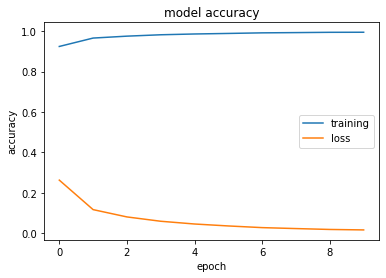

In [20]:
history = model.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=32,
    verbose=1
)

# Visualize accuracy and loss during training
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'loss'], loc='best')
plt.show()

In [21]:
model.save_weights('models/my_first_model.h5')

In [22]:
#model.load_weights('models/simple_fnn_30_epochs.h5')

## 4. Evaluate our model
In order to evaluate our model, we evaluate it on the test data

In [23]:
loss, accuracy  = model.evaluate(x_test, y_test, verbose=True)

print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

313/313 [==============================] - 0s 473us/step - loss: 0.0809 - accuracy: 0.9772
Test loss: 0.0809
Test accuracy: 0.977


<details><summary>Hint: </summary>
<p>
    
```python
score = model.evaluate(X_TESTING_DATA, Y_TESTING_DATA)
```
</p>

##  5. Let's have some fun

Here we'll use OpenCV and our trained model to perform predictions on images fed from our webcamera, in real time.

In [24]:
# MNIST PREPROCESSING
# Inspired by Ole Kröger (https://bit.ly/3jPiBMY)
import math
from scipy import ndimage


def get_best_shift(img):
    center_y , center_x = ndimage.measurements.center_of_mass(img)

    rows, cols = img.shape
    shift_y = np.round(rows//2 - center_y)
    shift_x = np.round(cols//2 - center_x)

    return shift_x, shift_y


def shift(img, sx, sy):
    rows,cols = img.shape
    M = np.float32([[1,0,sx],[0,1,sy]])
    shifted = cv.warpAffine(img,M,(cols,rows))
    return shifted


def mnist_preprocessing(image, dim=28, box=20):
    resized_image = cv.resize(image, dsize=(dim, dim), interpolation=cv.INTER_LINEAR)
    gray = np.asarray(cv.cvtColor(resized_image, cv.COLOR_BGR2GRAY))
    gray = 255 - gray
    gray = cv.resize(gray, (dim, dim))
    _, thresh = cv.threshold(gray, 128, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    
    
    while np.sum(gray[0]) == 0:
        gray = gray[1:]

    while np.sum(gray[:,0]) == 0:
        gray = np.delete(gray, 0, 1)

    while np.sum(gray[-1]) == 0:
        gray = gray[:-1]

    while np.sum(gray[:,-1]) == 0:
        gray = np.delete(gray, -1, 1)

    rows,cols = gray.shape

    if rows > cols:
        factor = box/rows
        rows = box
        cols = int(round(cols*factor))
        gray = cv.resize(gray, (cols,rows))
    else:
        factor = box/cols
        cols = box
        rows = int(round(rows*factor))
        gray = cv.resize(gray, (cols, rows))

    colsPadding = (int(math.ceil((dim - cols)/2.0)),int(math.floor((dim - cols)/2.0)))
    rowsPadding = (int(math.ceil((dim - rows)/2.0)),int(math.floor((dim - rows)/2.0)))
    gray = np.pad(gray, (rowsPadding, colsPadding), 'constant')

    shiftx,shifty = get_best_shift(gray)
    shifted = shift(gray,shiftx,shifty)
    
    normalized_img = normalize(shifted)
    
    return shifted

In [25]:
def predict_single_image(model, img):
    img = np.expand_dims(img, axis=0)     # --> (1, 28, 28)
    img = np.reshape(img, [1, 28, 28, 1]) # --> (1, 28, 28, 1)
    pred = model.predict(img)
    label = np.argmax(pred[:1])
    
    return label

In [ ]:
cap = cv.VideoCapture(0) 

init_frame_read_correctly, init_frame = cap.read()
if not init_frame_read_correctly:
        print("No frames to read...")
        

bounding_box = (init_frame.shape[1]//4, init_frame.shape[0]//4,
                init_frame.shape[1]//2, init_frame.shape[0]//2)    

while(cap.isOpened()):
    # Capture frame-by-frame
    frame_read_correctly, frame = cap.read()
    if not frame_read_correctly:
        print("No frames to read...")
        break
    
    
    # new_bounding_box = bounding_box
    wh = (frame.shape[1]//frame.shape[0])*200
    if frame_read_correctly:
        point1 = (frame.shape[1]//2 - wh, frame.shape[0]//2 - wh)
        point2 = (frame.shape[1]//2 + wh, frame.shape[0]//2 + wh)
        cv.rectangle(frame, point1, point2, (255, 255, 0), 2)
        

    try:
        # Crop out new ROI and process it
        new_ROI = frame[frame.shape[0]//2 - wh :frame.shape[0]//2 + wh, frame.shape[1]//2 - wh:frame.shape[1]//2 + wh]
        img = mnist_preprocessing(new_ROI)
        label = predict_single_image(model, img)

        cv.namedWindow('processed', 0)
        cv.imshow('processed', img)
        
    except Exception as e:
        print(f"Exception occured:\n{e}")
        pass

    
    # Display the resulting pred
    cv.putText(frame,
               f"{label}",
               org=(point2[0] - 75, point2[1] + 75),
               fontFace=cv.FONT_HERSHEY_PLAIN,
               fontScale=5,
               color=(255, 255, 0),
               thickness=2,
               lineType=cv.LINE_AA
              )
    
    cv.namedWindow('frame', 0)
    cv.resizeWindow('frame', 640, 480)
    cv.imshow('frame', frame)
    #cv.imshow('box', new_ROI)

    # Listen for keypress
    # SINCE OpenCV videoCapture inside a Jupyter Notebook Kernel is 'kinda broken'
    # one needs to quit the OpenCV-windows hard..
    # MacOS --> CMD+Q
    # MacOS --> ALT+F4
    if cv.waitKey(1) & 0xFF == ord('q'):
        break
        
    
# Release the capture afterward
cap.release()
cv.destroyAllWindows()